In [1]:
import torch
import torch.nn as nn
import torch.optim as optim
from torchvision import datasets, transforms, models
from torch.utils.data import Dataset
from torch.utils.data import DataLoader, random_split
from sklearn.metrics import classification_report, confusion_matrix
from tqdm import tqdm
from PIL import Image
import random
import warnings
from collections import Counter
warnings.filterwarnings("ignore")

In [2]:
import torch
print(torch.__version__)  # Check PyTorch version
print(torch.version.cuda)  # Check CUDA version PyTorch was built with

2.5.1+cu121
12.1


In [3]:
import torch
print("CUDA Available:", torch.cuda.is_available())
print("GPU Name:", torch.cuda.get_device_name(0) if torch.cuda.is_available() else "No GPU found")

CUDA Available: True
GPU Name: NVIDIA GeForce GTX 1650


In [4]:
!nvidia-smi

Sun Feb  9 23:14:11 2025       
+-----------------------------------------------------------------------------------------+
| NVIDIA-SMI 572.16                 Driver Version: 572.16         CUDA Version: 12.8     |
|-----------------------------------------+------------------------+----------------------+
| GPU  Name                  Driver-Model | Bus-Id          Disp.A | Volatile Uncorr. ECC |
| Fan  Temp   Perf          Pwr:Usage/Cap |           Memory-Usage | GPU-Util  Compute M. |
|                                         |                        |               MIG M. |
|=========================================+========================+======================|
|   0  NVIDIA GeForce GTX 1650      WDDM  |   00000000:01:00.0 Off |                  N/A |
| N/A   55C    P0             15W /   50W |       0MiB /   4096MiB |      0%      Default |
|                                         |                        |                  N/A |
+-----------------------------------------+-----

In [5]:
# Define transformations (Resize, Normalize, Augment)
transform = transforms.Compose([
    transforms.Resize((224, 224)),
    transforms.RandomHorizontalFlip(),
    transforms.RandomRotation(10),
    transforms.ToTensor(),
    transforms.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225])
])

In [6]:
# Assuming dataset is a folder-based ImageFolder dataset
dataset = datasets.ImageFolder("thermal", transform=transform)

# Count occurrences of each class
class_counts = Counter([label for _, label in dataset.samples])
max_count = max(class_counts.values())  # Find the class with the highest count

print(class_counts)  # Print class distribution


Counter({0: 220, 3: 142, 2: 93, 5: 80, 1: 67, 4: 34})


In [7]:
# Split dataset into 60% Train, 20% Validation, 20% Test
train_size = int(0.6 * len(dataset))
val_size = int(0.2 * len(dataset))
test_size = len(dataset) - train_size - val_size  # Remaining samples go to test

train_data, val_data, test_data = random_split(dataset, [train_size, val_size, test_size])

In [8]:
# Create DataLoaders
train_loader = DataLoader(train_data, batch_size=32, shuffle=True, num_workers=0)
val_loader = DataLoader(val_data, batch_size=32, shuffle=False, num_workers=0)
test_loader = DataLoader(test_data, batch_size=32, shuffle=False, num_workers=0)

## Demo 1

In [14]:
# import torch
# import torch.nn as nn
# import torch.optim as optim
# import torchvision.models as models
# from tqdm import tqdm
# from sklearn.metrics import classification_report, confusion_matrix

# def train_model1(model_name, train_loader, val_loader, num_classes=6, num_epochs=20, lr=0.0001):
#     device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
#     print(f"\nUsing device: {device}\n")

#     model_dict = {
#         "ResNet50": models.resnet50,
#         "ResNet101": models.resnet101,
#         "EfficientNetV2": models.efficientnet_v2_s,
#         "ViT": models.vit_b_16,
#         "GoogleNet": models.googlenet,
#         "InceptionV3": models.inception_v3,
#         "VGG16": models.vgg16,
#         "AlexNet": models.alexnet,
#         "DenseNet": models.densenet121,
#         "MobileNetV2": models.mobilenet_v2,
#         "RCNN": models.detection.fasterrcnn_resnet50_fpn
#     }

#     if model_name not in model_dict:
#         raise ValueError(f"Model '{model_name}' not supported!")

#     model = model_dict[model_name](pretrained=True)

#     if model_name in ["ResNet50", "ResNet101", "GoogleNet", "InceptionV3"]:
#         model.fc = nn.Linear(model.fc.in_features, num_classes)
#     elif "efficientnet" in model_name.lower():
#         model.classifier[1] = nn.Linear(model.classifier[1].in_features, num_classes)
#     elif "vit" in model_name.lower():
#         model.heads.head = nn.Linear(model.heads.head.in_features, num_classes)
#     elif model_name == "VGG16" or model_name == "AlexNet":
#         model.classifier[6] = nn.Linear(model.classifier[6].in_features, num_classes)
#     elif model_name == "DenseNet":
#         model.classifier = nn.Linear(model.classifier.in_features, num_classes)
#     elif model_name == "MobileNetV2":
#         model.classifier[1] = nn.Linear(model.classifier[1].in_features, num_classes)
#     elif model_name == "RCNN":
#         in_features = model.roi_heads.box_predictor.cls_score.in_features
#         model.roi_heads.box_predictor = models.detection.faster_rcnn.FastRCNNPredictor(in_features, num_classes)
    
#     model = model.to(device)
#     criterion = nn.CrossEntropyLoss()
#     optimizer = optim.Adam(model.parameters(), lr=lr)

#     print(f"\nTraining {model_name} for {num_epochs} epochs...\n")
#     for epoch in range(num_epochs):
#         model.train()
#         running_loss, correct, total = 0.0, 0, 0
#         progress_bar = tqdm(train_loader, desc=f"Epoch {epoch+1}/{num_epochs}", leave=True)

#         for images, labels in progress_bar:
#             images, labels = images.to(device), labels.to(device)
#             optimizer.zero_grad()
#             outputs = model(images)
#             loss = criterion(outputs, labels)
#             loss.backward()
#             optimizer.step()

#             running_loss += loss.item()
#             _, preds = torch.max(outputs, 1)
#             correct += (preds == labels).sum().item()
#             total += labels.size(0)

#             progress_bar.set_postfix(loss=running_loss / len(train_loader), accuracy=100 * correct / total)

#         print(f"Epoch {epoch+1}: Loss = {running_loss / len(train_loader):.4f}, Accuracy = {100 * correct / total:.2f}%")

#     def evaluate_model(loader, dataset_type="Validation"):
#         model.eval()
#         correct, total, y_true, y_pred = 0, 0, [], []
#         with torch.no_grad():
#             for images, labels in tqdm(loader, desc=f"🔍 Evaluating {dataset_type} Set", leave=True):
#                 images, labels = images.to(device), labels.to(device)
#                 outputs = model(images)
#                 _, preds = torch.max(outputs, 1)
#                 y_true.extend(labels.cpu().numpy())
#                 y_pred.extend(preds.cpu().numpy())
#                 correct += (preds == labels).sum().item()
#                 total += labels.size(0)
#         accuracy = 100 * correct / total
#         print(f"\n{dataset_type} Set Accuracy: {accuracy:.2f}%")
#         print(classification_report(y_true, y_pred))
#         print(confusion_matrix(y_true, y_pred))

#     evaluate_model(val_loader, "Validation")
#     evaluate_model(test_loader, "Testing")
#     return model


In [15]:
trained_model = train_model1("MobileNetV2", train_loader, val_loader, num_classes=6, num_epochs=20, lr=0.0001)


Using device: cuda


Training MobileNetV2 for 20 epochs...



Epoch 1/20:   0%|                                                                               | 0/12 [02:00<?, ?it/s]


KeyboardInterrupt: 

## CODE 1

### 1

In [9]:
# import torch
# import torch.nn as nn
# import torch.optim as optim
# import torchvision.models as models
# from tqdm import tqdm
# from sklearn.metrics import classification_report, confusion_matrix

# def train_model(model_name, train_loader, val_loader, num_classes=6, num_epochs=20, lr=0.0001):
#     # Select device (GPU if available)
#     device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
#     print(f"\n Using device: {device}\n")

#     # Load the requested model
#     model_dict = {
#         "ResNet50": models.resnet50,
#         "ResNet101": models.resnet101,
#         "EfficientNetV2": models.efficientnet_v2_s,
#         "ViT": models.vit_b_16,
#         "GoogleNet": models.googlenet,
#         "InceptionV3": models.inception_v3,
#         "VGG16": models.vgg16,
#         "AlexNet": models.alexnet
#     }

#     if model_name not in model_dict:
#         raise ValueError(f" Model '{model_name}' not supported!")

#     model = model_dict[model_name](pretrained=True)

#     # Adjust the classifier for 6 classes
#     if "resnet" in model_name.lower() or "googlenet" in model_name.lower():
#         model.fc = nn.Linear(model.fc.in_features, num_classes)
#     elif "efficientnet" in model_name.lower():
#         model.classifier[1] = nn.Linear(model.classifier[1].in_features, num_classes)
#     elif "vit" in model_name.lower():
#         model.heads.head = nn.Linear(model.heads.head.in_features, num_classes)
#     elif "inception" in model_name.lower():
#         model.fc = nn.Linear(model.fc.in_features, num_classes)
#     elif "vgg" in model_name.lower() or "alexnet" in model_name.lower():
#         model.classifier[6] = nn.Linear(model.classifier[6].in_features, num_classes)

#     # Move model to device
#     model = model.to(device)

#     # Define loss function and optimizer
#     criterion = nn.CrossEntropyLoss()
#     optimizer = optim.Adam(model.parameters(), lr=lr)

#     # Training Loop with tqdm
#     print(f"\nTraining {model_name} for {num_epochs} epochs...\n")
#     for epoch in range(num_epochs):
#         model.train()
#         running_loss, correct, total = 0.0, 0, 0
#         progress_bar = tqdm(train_loader, desc=f"Epoch {epoch+1}/{num_epochs}", leave=True)

#         for images, labels in progress_bar:
#             images, labels = images.to(device), labels.to(device)
#             optimizer.zero_grad()
#             outputs = model(images)
#             loss = criterion(outputs, labels)
#             loss.backward()
#             optimizer.step()

#             running_loss += loss.item()
#             _, preds = torch.max(outputs, 1)
#             correct += (preds == labels).sum().item()
#             total += labels.size(0)

#             # Update tqdm progress bar
#             progress_bar.set_postfix(loss=running_loss / len(train_loader), accuracy=100 * correct / total)

#         print(f" Epoch {epoch+1}: Loss = {running_loss / len(train_loader):.4f}, Accuracy = {100 * correct / total:.2f}%")

#     # Evaluation Function
#     def evaluate_model(loader, dataset_type="Validation"):
#         model.eval()
#         correct, total, y_true, y_pred = 0, 0, [], []

#         with torch.no_grad():
#             for images, labels in tqdm(loader, desc=f"🔍 Evaluating {dataset_type} Set", leave=True):
#                 images, labels = images.to(device), labels.to(device)
#                 outputs = model(images)
#                 _, preds = torch.max(outputs, 1)

#                 y_true.extend(labels.cpu().numpy())
#                 y_pred.extend(preds.cpu().numpy())
#                 correct += (preds == labels).sum().item()
#                 total += labels.size(0)

#         accuracy = 100 * correct / total
#         print(f"\n{dataset_type} Set Accuracy: {accuracy:.2f}%")
#         print(classification_report(y_true, y_pred))
#         print(confusion_matrix(y_true, y_pred))

#     # Evaluate on Validation Set
#     evaluate_model(val_loader, "Validation")
#     evaluate_model(test_loader, "Test")

#     return model


### 2

In [9]:
import torch
import torch.nn as nn
import torch.optim as optim
import torchvision.models as models
from tqdm import tqdm
import numpy as np
import matplotlib.pyplot as plt
from sklearn.metrics import classification_report, confusion_matrix, precision_recall_curve

def train_model(model_name, train_loader, val_loader, num_classes=6, num_epochs=20, lr=0.0001):
    # Select GPU device
    if not torch.cuda.is_available():
        raise RuntimeError("GPU not available. This code requires a GPU to run.")
    device = torch.device("cuda")
    gpu_name = torch.cuda.get_device_name(device)
    print(f"\nUsing device: {device} ({gpu_name})\n")

    # Load the requested model
    model_dict = {
        "ResNet50": models.resnet50,
        "ResNet101": models.resnet101,
        "EfficientNetV2": models.efficientnet_v2_s,
        "ViT": models.vit_b_16,
        "GoogleNet": models.googlenet,
        "InceptionV3": models.inception_v3,
        "VGG16": models.vgg16,
        "AlexNet": models.alexnet
    }

    if model_name not in model_dict:
        raise ValueError(f"Model '{model_name}' not supported!")

    model = model_dict[model_name](pretrained=True)

    # Adjust the classifier for 6 classes
    if "resnet" in model_name.lower() or "googlenet" in model_name.lower():
        model.fc = nn.Linear(model.fc.in_features, num_classes)
    elif "efficientnet" in model_name.lower():
        model.classifier[1] = nn.Linear(model.classifier[1].in_features, num_classes)
    elif "vit" in model_name.lower():
        model.heads.head = nn.Linear(model.heads.head.in_features, num_classes)
    elif "inception" in model_name.lower():
        model.fc = nn.Linear(model.fc.in_features, num_classes)
    elif "vgg" in model_name.lower() or "alexnet" in model_name.lower():
        model.classifier[6] = nn.Linear(model.classifier[6].in_features, num_classes)

    # Move model to device
    model = model.to(device)

    # Define loss function and optimizer
    criterion = nn.CrossEntropyLoss()
    optimizer = optim.Adam(model.parameters(), lr=lr)

    # Training Loop with tqdm
    print(f"\nTraining {model_name} for {num_epochs} epochs...\n")
    for epoch in range(num_epochs):
        model.train()
        running_loss, correct, total = 0.0, 0, 0
        progress_bar = tqdm(train_loader, desc=f"Epoch {epoch+1}/{num_epochs}", leave=True)

        for images, labels in progress_bar:
            images, labels = images.to(device), labels.to(device)
            optimizer.zero_grad()
            outputs = model(images)
            loss = criterion(outputs, labels)
            loss.backward()
            optimizer.step()

            running_loss += loss.item()
            _, preds = torch.max(outputs, 1)
            correct += (preds == labels).sum().item()
            total += labels.size(0)

            # Update tqdm progress bar
            progress_bar.set_postfix(loss=running_loss / len(train_loader), accuracy=100 * correct / total)

        print(f"Epoch {epoch+1}: Loss = {running_loss / len(train_loader):.4f}, Accuracy = {100 * correct / total:.2f}%")

    # Evaluation Function with PR Curve
    def evaluate_model(loader, dataset_type="Validation"):
        model.eval()
        correct, total = 0, 0
        y_true, y_pred, y_scores = [], [], []

        with torch.no_grad():
            for images, labels in tqdm(loader, desc=f"🔍 Evaluating {dataset_type} Set", leave=True):
                images, labels = images.to(device), labels.to(device)
                outputs = model(images)
                _, preds = torch.max(outputs, 1)

                y_true.extend(labels.cpu().numpy())
                y_pred.extend(preds.cpu().numpy())
                y_scores.extend(torch.softmax(outputs, dim=1).cpu().numpy())  # Get probabilities

                correct += (preds == labels).sum().item()
                total += labels.size(0)

        accuracy = 100 * correct / total
        print(f"\n{dataset_type} Set Accuracy: {accuracy:.2f}%")
        print(classification_report(y_true, y_pred))
        print(confusion_matrix(y_true, y_pred))

        # 🔹 Precision-Recall Curve Plot
        y_true_one_hot = np.eye(num_classes)[y_true]  # Convert to one-hot encoding

        plt.figure(figsize=(10, 6))
        for class_idx in range(num_classes):
            precision, recall, _ = precision_recall_curve(y_true_one_hot[:, class_idx], np.array(y_scores)[:, class_idx])
            plt.plot(recall, precision, label=f'Class {class_idx}')

        plt.xlabel('Recall')
        plt.ylabel('Precision')
        plt.title(f'Precision-Recall Curve for {dataset_type} Set')
        plt.legend()
        plt.grid()
        plt.show()

    # Evaluate on Validation Set
    evaluate_model(val_loader, "Validation")
    evaluate_model(test_loader, "Testing")

    return model


### ResNet50


Using device: cuda (NVIDIA GeForce GTX 1650)


Training ResNet50 for 20 epochs...



Epoch 1/20: 100%|████████████████████████████████████████████| 12/12 [00:49<00:00,  4.10s/it, accuracy=47.2, loss=1.41]


Epoch 1: Loss = 1.4123, Accuracy = 47.24%


Epoch 2/20: 100%|███████████████████████████████████████████| 12/12 [00:47<00:00,  3.99s/it, accuracy=71.4, loss=0.741]


Epoch 2: Loss = 0.7409, Accuracy = 71.39%


Epoch 3/20: 100%|███████████████████████████████████████████| 12/12 [00:47<00:00,  3.99s/it, accuracy=89.5, loss=0.362]


Epoch 3: Loss = 0.3620, Accuracy = 89.50%


Epoch 4/20: 100%|███████████████████████████████████████████| 12/12 [00:47<00:00,  3.99s/it, accuracy=94.5, loss=0.218]


Epoch 4: Loss = 0.2183, Accuracy = 94.49%


Epoch 5/20: 100%|███████████████████████████████████████████| 12/12 [00:47<00:00,  3.98s/it, accuracy=95.8, loss=0.152]


Epoch 5: Loss = 0.1523, Accuracy = 95.80%


Epoch 6/20: 100%|███████████████████████████████████████████| 12/12 [00:47<00:00,  3.98s/it, accuracy=95.3, loss=0.135]


Epoch 6: Loss = 0.1352, Accuracy = 95.28%


Epoch 7/20: 100%|███████████████████████████████████████████| 12/12 [00:47<00:00,  3.98s/it, accuracy=95.3, loss=0.134]


Epoch 7: Loss = 0.1336, Accuracy = 95.28%


Epoch 8/20: 100%|███████████████████████████████████████████| 12/12 [00:47<00:00,  3.99s/it, accuracy=97.1, loss=0.119]


Epoch 8: Loss = 0.1189, Accuracy = 97.11%


Epoch 9/20: 100%|██████████████████████████████████████████| 12/12 [00:47<00:00,  3.98s/it, accuracy=98.4, loss=0.0622]


Epoch 9: Loss = 0.0622, Accuracy = 98.43%


Epoch 10/20: 100%|█████████████████████████████████████████| 12/12 [00:47<00:00,  3.98s/it, accuracy=98.4, loss=0.0581]


Epoch 10: Loss = 0.0581, Accuracy = 98.43%


Epoch 11/20: 100%|█████████████████████████████████████████| 12/12 [00:47<00:00,  3.98s/it, accuracy=99.5, loss=0.0576]


Epoch 11: Loss = 0.0576, Accuracy = 99.48%


Epoch 12/20: 100%|█████████████████████████████████████████| 12/12 [00:47<00:00,  3.98s/it, accuracy=98.7, loss=0.0493]


Epoch 12: Loss = 0.0493, Accuracy = 98.69%


Epoch 13/20: 100%|█████████████████████████████████████████| 12/12 [00:47<00:00,  3.98s/it, accuracy=99.2, loss=0.0247]


Epoch 13: Loss = 0.0247, Accuracy = 99.21%


Epoch 14/20: 100%|█████████████████████████████████████████| 12/12 [00:47<00:00,  4.00s/it, accuracy=99.5, loss=0.0314]


Epoch 14: Loss = 0.0314, Accuracy = 99.48%


Epoch 15/20: 100%|██████████████████████████████████████████| 12/12 [00:47<00:00,  3.98s/it, accuracy=100, loss=0.0117]


Epoch 15: Loss = 0.0117, Accuracy = 100.00%


Epoch 16/20: 100%|█████████████████████████████████████████| 12/12 [00:47<00:00,  3.99s/it, accuracy=99.7, loss=0.0178]


Epoch 16: Loss = 0.0178, Accuracy = 99.74%


Epoch 17/20: 100%|█████████████████████████████████████████| 12/12 [00:47<00:00,  3.99s/it, accuracy=99.7, loss=0.0127]


Epoch 17: Loss = 0.0127, Accuracy = 99.74%


Epoch 18/20: 100%|█████████████████████████████████████████| 12/12 [00:47<00:00,  3.98s/it, accuracy=100, loss=0.00936]


Epoch 18: Loss = 0.0094, Accuracy = 100.00%


Epoch 19/20: 100%|█████████████████████████████████████████| 12/12 [00:47<00:00,  3.99s/it, accuracy=99.5, loss=0.0316]


Epoch 19: Loss = 0.0316, Accuracy = 99.48%


Epoch 20/20: 100%|█████████████████████████████████████████| 12/12 [00:47<00:00,  3.98s/it, accuracy=98.4, loss=0.0383]


Epoch 20: Loss = 0.0383, Accuracy = 98.43%


🔍 Evaluating Validation Set: 100%|██████████████████████████████████████████████████████| 4/4 [00:03<00:00,  1.06it/s]



Validation Set Accuracy: 90.55%
              precision    recall  f1-score   support

           0       0.83      0.96      0.89        45
           1       1.00      1.00      1.00         8
           2       0.94      0.75      0.83        20
           3       0.97      0.91      0.94        32
           4       1.00      1.00      1.00         5
           5       0.94      0.88      0.91        17

    accuracy                           0.91       127
   macro avg       0.94      0.92      0.93       127
weighted avg       0.91      0.91      0.91       127

[[43  0  0  1  0  1]
 [ 0  8  0  0  0  0]
 [ 5  0 15  0  0  0]
 [ 3  0  0 29  0  0]
 [ 0  0  0  0  5  0]
 [ 1  0  1  0  0 15]]


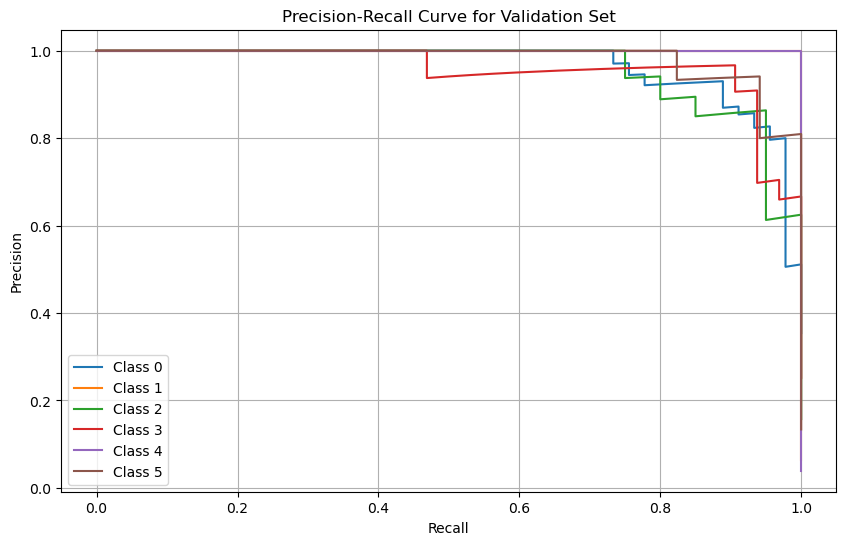

🔍 Evaluating Testing Set: 100%|█████████████████████████████████████████████████████████| 4/4 [00:03<00:00,  1.10it/s]


Testing Set Accuracy: 94.53%
              precision    recall  f1-score   support

           0       0.95      1.00      0.97        38
           1       1.00      0.81      0.90        16
           2       0.87      0.91      0.89        22
           3       1.00      1.00      1.00        28
           4       1.00      1.00      1.00         6
           5       0.89      0.89      0.89        18

    accuracy                           0.95       128
   macro avg       0.95      0.94      0.94       128
weighted avg       0.95      0.95      0.94       128

[[38  0  0  0  0  0]
 [ 0 13  3  0  0  0]
 [ 0  0 20  0  0  2]
 [ 0  0  0 28  0  0]
 [ 0  0  0  0  6  0]
 [ 2  0  0  0  0 16]]


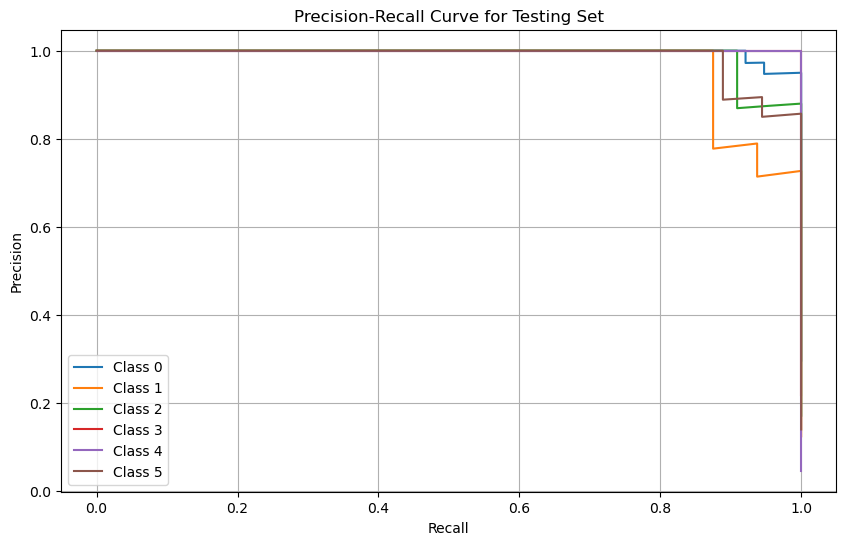

In [21]:
trained_model = train_model("ResNet50", train_loader, val_loader, num_classes=6, num_epochs=20, lr=0.0001)

### ResNet101


Using device: cuda (NVIDIA GeForce GTX 1650)


Training ResNet101 for 20 epochs...



Epoch 1/20: 100%|████████████████████████████████████████████| 12/12 [01:06<00:00,  5.51s/it, accuracy=51.2, loss=1.37]


Epoch 1: Loss = 1.3651, Accuracy = 51.18%


Epoch 2/20: 100%|███████████████████████████████████████████| 12/12 [01:05<00:00,  5.48s/it, accuracy=80.8, loss=0.599]


Epoch 2: Loss = 0.5995, Accuracy = 80.84%


Epoch 3/20: 100%|███████████████████████████████████████████| 12/12 [01:05<00:00,  5.47s/it, accuracy=93.4, loss=0.279]


Epoch 3: Loss = 0.2785, Accuracy = 93.44%


Epoch 4/20: 100%|███████████████████████████████████████████| 12/12 [01:06<00:00,  5.52s/it, accuracy=94.2, loss=0.208]


Epoch 4: Loss = 0.2081, Accuracy = 94.23%


Epoch 5/20: 100%|███████████████████████████████████████████| 12/12 [01:06<00:00,  5.52s/it, accuracy=93.2, loss=0.223]


Epoch 5: Loss = 0.2233, Accuracy = 93.18%


Epoch 6/20: 100%|███████████████████████████████████████████| 12/12 [01:06<00:00,  5.53s/it, accuracy=94.2, loss=0.176]


Epoch 6: Loss = 0.1761, Accuracy = 94.23%


Epoch 7/20: 100%|██████████████████████████████████████████| 12/12 [01:06<00:00,  5.52s/it, accuracy=98.2, loss=0.0732]


Epoch 7: Loss = 0.0732, Accuracy = 98.16%


Epoch 8/20: 100%|██████████████████████████████████████████| 12/12 [01:06<00:00,  5.52s/it, accuracy=98.2, loss=0.0552]


Epoch 8: Loss = 0.0552, Accuracy = 98.16%


Epoch 9/20: 100%|████████████████████████████████████████████| 12/12 [01:06<00:00,  5.52s/it, accuracy=99, loss=0.0385]


Epoch 9: Loss = 0.0385, Accuracy = 98.95%


Epoch 10/20: 100%|███████████████████████████████████████████| 12/12 [01:06<00:00,  5.53s/it, accuracy=99, loss=0.0387]


Epoch 10: Loss = 0.0387, Accuracy = 98.95%


Epoch 11/20: 100%|██████████████████████████████████████████| 12/12 [01:06<00:00,  5.53s/it, accuracy=98.4, loss=0.054]


Epoch 11: Loss = 0.0540, Accuracy = 98.43%


Epoch 12/20: 100%|█████████████████████████████████████████| 12/12 [01:06<00:00,  5.53s/it, accuracy=98.2, loss=0.0505]


Epoch 12: Loss = 0.0505, Accuracy = 98.16%


Epoch 13/20: 100%|█████████████████████████████████████████| 12/12 [01:06<00:00,  5.53s/it, accuracy=96.9, loss=0.0857]


Epoch 13: Loss = 0.0857, Accuracy = 96.85%


Epoch 14/20: 100%|█████████████████████████████████████████| 12/12 [01:06<00:00,  5.53s/it, accuracy=98.2, loss=0.0663]


Epoch 14: Loss = 0.0663, Accuracy = 98.16%


Epoch 15/20: 100%|█████████████████████████████████████████| 12/12 [01:06<00:00,  5.52s/it, accuracy=98.7, loss=0.0512]


Epoch 15: Loss = 0.0512, Accuracy = 98.69%


Epoch 16/20: 100%|█████████████████████████████████████████| 12/12 [01:06<00:00,  5.53s/it, accuracy=99.5, loss=0.0343]


Epoch 16: Loss = 0.0343, Accuracy = 99.48%


Epoch 17/20: 100%|█████████████████████████████████████████| 12/12 [01:06<00:00,  5.53s/it, accuracy=98.7, loss=0.0614]


Epoch 17: Loss = 0.0614, Accuracy = 98.69%


Epoch 18/20: 100%|███████████████████████████████████████████| 12/12 [01:06<00:00,  5.52s/it, accuracy=99, loss=0.0369]


Epoch 18: Loss = 0.0369, Accuracy = 98.95%


Epoch 19/20: 100%|█████████████████████████████████████████| 12/12 [01:06<00:00,  5.52s/it, accuracy=99.5, loss=0.0278]


Epoch 19: Loss = 0.0278, Accuracy = 99.48%


Epoch 20/20: 100%|█████████████████████████████████████████| 12/12 [01:06<00:00,  5.53s/it, accuracy=98.7, loss=0.0356]


Epoch 20: Loss = 0.0356, Accuracy = 98.69%


🔍 Evaluating Validation Set: 100%|██████████████████████████████████████████████████████| 4/4 [00:02<00:00,  1.39it/s]



Validation Set Accuracy: 91.34%
              precision    recall  f1-score   support

           0       0.93      0.91      0.92        43
           1       0.93      0.81      0.87        16
           2       0.93      0.88      0.90        16
           3       1.00      0.97      0.98        33
           4       0.75      1.00      0.86         6
           5       0.75      0.92      0.83        13

    accuracy                           0.91       127
   macro avg       0.88      0.91      0.89       127
weighted avg       0.92      0.91      0.91       127

[[39  0  0  0  2  2]
 [ 1 13  1  0  0  1]
 [ 1  0 14  0  0  1]
 [ 0  1  0 32  0  0]
 [ 0  0  0  0  6  0]
 [ 1  0  0  0  0 12]]


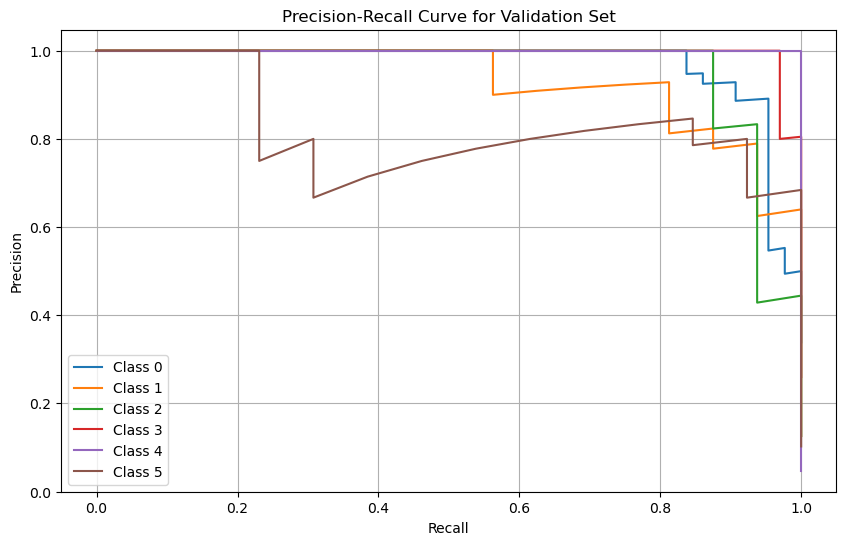

🔍 Evaluating Testing Set: 100%|█████████████████████████████████████████████████████████| 4/4 [00:02<00:00,  1.40it/s]



Testing Set Accuracy: 94.53%
              precision    recall  f1-score   support

           0       0.94      0.98      0.96        45
           1       0.94      0.94      0.94        16
           2       0.96      1.00      0.98        22
           3       0.96      0.96      0.96        25
           4       1.00      0.78      0.88         9
           5       0.90      0.82      0.86        11

    accuracy                           0.95       128
   macro avg       0.95      0.91      0.93       128
weighted avg       0.95      0.95      0.94       128

[[44  0  0  0  0  1]
 [ 0 15  1  0  0  0]
 [ 0  0 22  0  0  0]
 [ 1  0  0 24  0  0]
 [ 0  1  0  1  7  0]
 [ 2  0  0  0  0  9]]


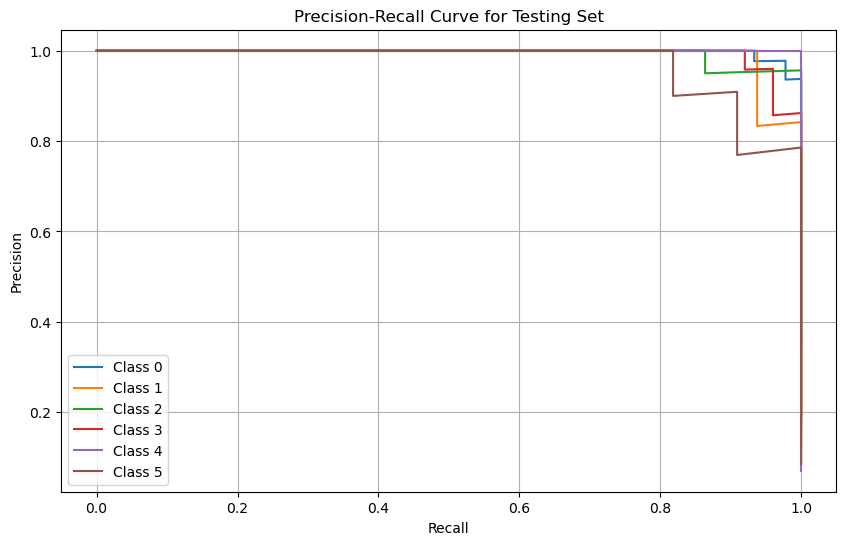

In [10]:
trained_model = train_model("ResNet101", train_loader, val_loader, num_classes=6, num_epochs=20, lr=0.0001)

### EfficientNetV2


Using device: cuda (NVIDIA GeForce GTX 1650)


Training EfficientNetV2 for 20 epochs...



Epoch 1/20: 100%|████████████████████████████████████████████| 12/12 [00:48<00:00,  4.04s/it, accuracy=37.8, loss=1.67]


Epoch 1: Loss = 1.6724, Accuracy = 37.80%


Epoch 2/20: 100%|████████████████████████████████████████████| 12/12 [00:47<00:00,  3.96s/it, accuracy=62.5, loss=1.32]


Epoch 2: Loss = 1.3250, Accuracy = 62.47%


Epoch 3/20: 100%|███████████████████████████████████████████| 12/12 [00:47<00:00,  3.96s/it, accuracy=77.2, loss=0.876]


Epoch 3: Loss = 0.8763, Accuracy = 77.17%


Epoch 4/20: 100%|███████████████████████████████████████████| 12/12 [00:47<00:00,  3.96s/it, accuracy=86.6, loss=0.554]


Epoch 4: Loss = 0.5536, Accuracy = 86.61%


Epoch 5/20: 100%|████████████████████████████████████████████| 12/12 [00:47<00:00,  3.96s/it, accuracy=91.3, loss=0.33]


Epoch 5: Loss = 0.3296, Accuracy = 91.34%


Epoch 6/20: 100%|███████████████████████████████████████████| 12/12 [00:47<00:00,  3.95s/it, accuracy=93.7, loss=0.243]


Epoch 6: Loss = 0.2435, Accuracy = 93.70%


Epoch 7/20: 100%|███████████████████████████████████████████| 12/12 [00:47<00:00,  3.96s/it, accuracy=96.6, loss=0.164]


Epoch 7: Loss = 0.1640, Accuracy = 96.59%


Epoch 8/20: 100%|███████████████████████████████████████████| 12/12 [00:47<00:00,  3.96s/it, accuracy=97.4, loss=0.104]


Epoch 8: Loss = 0.1042, Accuracy = 97.38%


Epoch 9/20: 100%|███████████████████████████████████████████| 12/12 [00:47<00:00,  3.96s/it, accuracy=97.4, loss=0.103]


Epoch 9: Loss = 0.1027, Accuracy = 97.38%


Epoch 10/20: 100%|██████████████████████████████████████████| 12/12 [00:47<00:00,  3.96s/it, accuracy=96.3, loss=0.106]


Epoch 10: Loss = 0.1056, Accuracy = 96.33%


Epoch 11/20: 100%|█████████████████████████████████████████| 12/12 [00:47<00:00,  3.96s/it, accuracy=98.2, loss=0.0717]


Epoch 11: Loss = 0.0717, Accuracy = 98.16%


Epoch 12/20: 100%|█████████████████████████████████████████| 12/12 [00:47<00:00,  3.95s/it, accuracy=99.2, loss=0.0485]


Epoch 12: Loss = 0.0485, Accuracy = 99.21%


Epoch 13/20: 100%|█████████████████████████████████████████| 12/12 [00:47<00:00,  3.96s/it, accuracy=99.5, loss=0.0516]


Epoch 13: Loss = 0.0516, Accuracy = 99.48%


Epoch 14/20: 100%|█████████████████████████████████████████| 12/12 [00:47<00:00,  3.96s/it, accuracy=98.4, loss=0.0412]


Epoch 14: Loss = 0.0412, Accuracy = 98.43%


Epoch 15/20: 100%|████████████████████████████████████████████| 12/12 [00:47<00:00,  3.96s/it, accuracy=99, loss=0.041]


Epoch 15: Loss = 0.0410, Accuracy = 98.95%


Epoch 16/20: 100%|█████████████████████████████████████████| 12/12 [00:47<00:00,  3.96s/it, accuracy=99.2, loss=0.0366]


Epoch 16: Loss = 0.0366, Accuracy = 99.21%


Epoch 17/20: 100%|█████████████████████████████████████████| 12/12 [00:47<00:00,  3.98s/it, accuracy=98.4, loss=0.0561]


Epoch 17: Loss = 0.0561, Accuracy = 98.43%


Epoch 18/20: 100%|███████████████████████████████████████████| 12/12 [00:47<00:00,  3.96s/it, accuracy=99, loss=0.0379]


Epoch 18: Loss = 0.0379, Accuracy = 98.95%


Epoch 19/20: 100%|██████████████████████████████████████████| 12/12 [00:48<00:00,  4.03s/it, accuracy=100, loss=0.0179]


Epoch 19: Loss = 0.0179, Accuracy = 100.00%


Epoch 20/20: 100%|█████████████████████████████████████████| 12/12 [00:50<00:00,  4.21s/it, accuracy=99.7, loss=0.0185]


Epoch 20: Loss = 0.0185, Accuracy = 99.74%


🔍 Evaluating Validation Set: 100%|██████████████████████████████████████████████████████| 4/4 [00:05<00:00,  1.26s/it]



Validation Set Accuracy: 89.76%
              precision    recall  f1-score   support

           0       0.97      0.84      0.90        43
           1       0.93      0.88      0.90        16
           2       0.88      0.88      0.88        16
           3       0.97      0.97      0.97        33
           4       0.67      1.00      0.80         6
           5       0.71      0.92      0.80        13

    accuracy                           0.90       127
   macro avg       0.85      0.91      0.87       127
weighted avg       0.91      0.90      0.90       127

[[36  0  1  0  3  3]
 [ 1 14  0  1  0  0]
 [ 0  0 14  0  0  2]
 [ 0  1  0 32  0  0]
 [ 0  0  0  0  6  0]
 [ 0  0  1  0  0 12]]


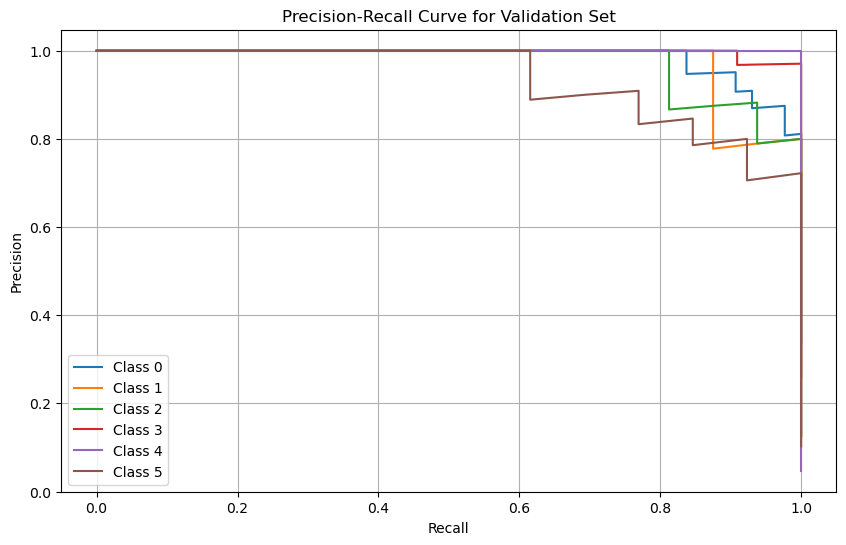

🔍 Evaluating Testing Set: 100%|█████████████████████████████████████████████████████████| 4/4 [00:05<00:00,  1.43s/it]


Testing Set Accuracy: 96.09%
              precision    recall  f1-score   support

           0       0.96      0.98      0.97        45
           1       0.94      0.94      0.94        16
           2       1.00      0.95      0.98        22
           3       0.96      0.92      0.94        25
           4       1.00      1.00      1.00         9
           5       0.92      1.00      0.96        11

    accuracy                           0.96       128
   macro avg       0.96      0.96      0.96       128
weighted avg       0.96      0.96      0.96       128

[[44  0  0  0  0  1]
 [ 0 15  0  1  0  0]
 [ 0  1 21  0  0  0]
 [ 2  0  0 23  0  0]
 [ 0  0  0  0  9  0]
 [ 0  0  0  0  0 11]]


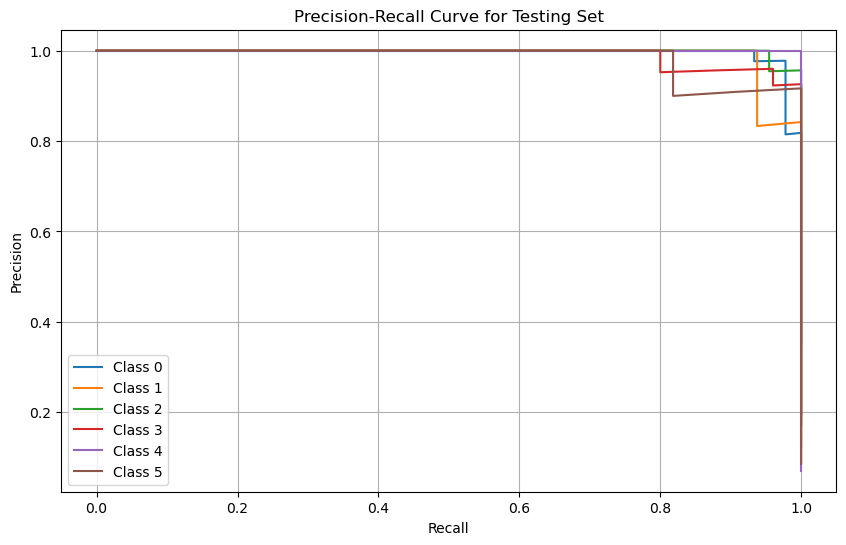

In [11]:
trained_model = train_model("EfficientNetV2", train_loader, val_loader, num_classes=6, num_epochs=20, lr=0.0001)

### ViT


Using device: cuda (NVIDIA GeForce GTX 1650)


Training ViT for 20 epochs...



Epoch 1/20: 100%|██████████████████████████████████████████████| 12/12 [02:49<00:00, 14.10s/it, accuracy=31, loss=1.73]


Epoch 1: Loss = 1.7277, Accuracy = 30.97%


Epoch 2/20: 100%|████████████████████████████████████████████| 12/12 [02:44<00:00, 13.71s/it, accuracy=54.6, loss=1.18]


Epoch 2: Loss = 1.1801, Accuracy = 54.59%


Epoch 3/20: 100%|███████████████████████████████████████████| 12/12 [02:44<00:00, 13.70s/it, accuracy=78.2, loss=0.657]


Epoch 3: Loss = 0.6565, Accuracy = 78.22%


Epoch 4/20: 100%|███████████████████████████████████████████| 12/12 [02:45<00:00, 13.75s/it, accuracy=86.9, loss=0.417]


Epoch 4: Loss = 0.4173, Accuracy = 86.88%


Epoch 5/20: 100%|███████████████████████████████████████████| 12/12 [02:44<00:00, 13.72s/it, accuracy=91.1, loss=0.277]


Epoch 5: Loss = 0.2771, Accuracy = 91.08%


Epoch 6/20: 100%|███████████████████████████████████████████| 12/12 [02:44<00:00, 13.72s/it, accuracy=91.9, loss=0.224]


Epoch 6: Loss = 0.2240, Accuracy = 91.86%


Epoch 7/20: 100%|███████████████████████████████████████████| 12/12 [02:44<00:00, 13.71s/it, accuracy=95.3, loss=0.147]


Epoch 7: Loss = 0.1473, Accuracy = 95.28%


Epoch 8/20: 100%|███████████████████████████████████████████| 12/12 [02:44<00:00, 13.73s/it, accuracy=95.8, loss=0.125]


Epoch 8: Loss = 0.1252, Accuracy = 95.80%


Epoch 9/20: 100%|██████████████████████████████████████████| 12/12 [02:44<00:00, 13.71s/it, accuracy=97.6, loss=0.0821]


Epoch 9: Loss = 0.0821, Accuracy = 97.64%


Epoch 10/20: 100%|█████████████████████████████████████████| 12/12 [02:44<00:00, 13.71s/it, accuracy=97.9, loss=0.0625]


Epoch 10: Loss = 0.0625, Accuracy = 97.90%


Epoch 11/20: 100%|█████████████████████████████████████████| 12/12 [02:44<00:00, 13.73s/it, accuracy=96.9, loss=0.0902]


Epoch 11: Loss = 0.0902, Accuracy = 96.85%


Epoch 12/20: 100%|█████████████████████████████████████████| 12/12 [02:44<00:00, 13.70s/it, accuracy=97.6, loss=0.0746]


Epoch 12: Loss = 0.0746, Accuracy = 97.64%


Epoch 13/20: 100%|█████████████████████████████████████████| 12/12 [02:44<00:00, 13.70s/it, accuracy=98.4, loss=0.0635]


Epoch 13: Loss = 0.0635, Accuracy = 98.43%


Epoch 14/20: 100%|█████████████████████████████████████████| 12/12 [02:44<00:00, 13.73s/it, accuracy=99.5, loss=0.0254]


Epoch 14: Loss = 0.0254, Accuracy = 99.48%


Epoch 15/20: 100%|███████████████████████████████████████████| 12/12 [02:44<00:00, 13.70s/it, accuracy=99, loss=0.0297]


Epoch 15: Loss = 0.0297, Accuracy = 98.95%


Epoch 16/20: 100%|█████████████████████████████████████████| 12/12 [02:44<00:00, 13.70s/it, accuracy=99.2, loss=0.0444]


Epoch 16: Loss = 0.0444, Accuracy = 99.21%


Epoch 17/20: 100%|█████████████████████████████████████████| 12/12 [02:44<00:00, 13.73s/it, accuracy=99.2, loss=0.0225]


Epoch 17: Loss = 0.0225, Accuracy = 99.21%


Epoch 18/20: 100%|█████████████████████████████████████████| 12/12 [02:44<00:00, 13.75s/it, accuracy=99.2, loss=0.0301]


Epoch 18: Loss = 0.0301, Accuracy = 99.21%


Epoch 19/20: 100%|█████████████████████████████████████████| 12/12 [02:44<00:00, 13.74s/it, accuracy=99.5, loss=0.0117]


Epoch 19: Loss = 0.0117, Accuracy = 99.48%


Epoch 20/20: 100%|█████████████████████████████████████████| 12/12 [02:44<00:00, 13.73s/it, accuracy=100, loss=0.00326]


Epoch 20: Loss = 0.0033, Accuracy = 100.00%


🔍 Evaluating Validation Set: 100%|██████████████████████████████████████████████████████| 4/4 [00:35<00:00,  8.95s/it]



Validation Set Accuracy: 90.55%
              precision    recall  f1-score   support

           0       0.87      0.95      0.91        43
           1       0.93      0.81      0.87        16
           2       1.00      0.88      0.93        16
           3       1.00      1.00      1.00        33
           4       0.67      1.00      0.80         6
           5       0.80      0.62      0.70        13

    accuracy                           0.91       127
   macro avg       0.88      0.88      0.87       127
weighted avg       0.91      0.91      0.90       127

[[41  0  0  0  2  0]
 [ 3 13  0  0  0  0]
 [ 0  0 14  0  0  2]
 [ 0  0  0 33  0  0]
 [ 0  0  0  0  6  0]
 [ 3  1  0  0  1  8]]


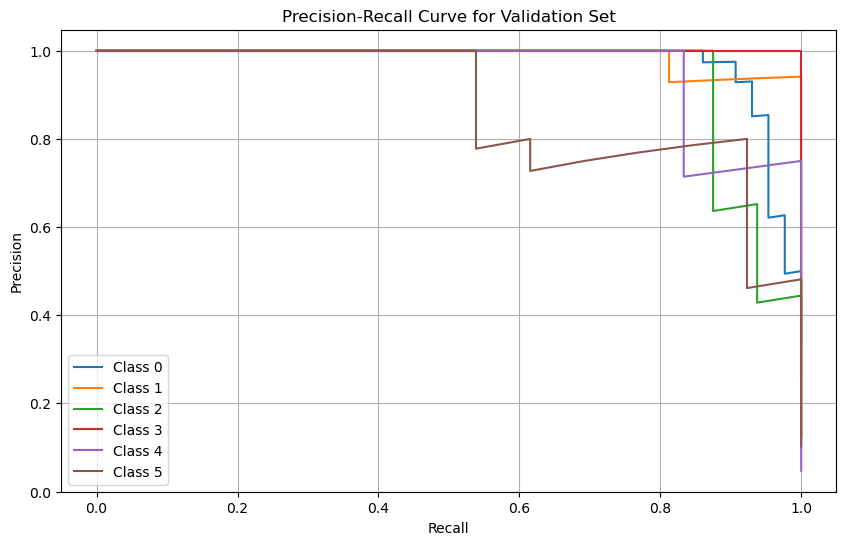

🔍 Evaluating Testing Set: 100%|█████████████████████████████████████████████████████████| 4/4 [00:36<00:00,  9.12s/it]


Testing Set Accuracy: 95.31%
              precision    recall  f1-score   support

           0       0.96      1.00      0.98        45
           1       0.88      0.94      0.91        16
           2       0.95      0.86      0.90        22
           3       0.96      0.96      0.96        25
           4       1.00      1.00      1.00         9
           5       1.00      0.91      0.95        11

    accuracy                           0.95       128
   macro avg       0.96      0.95      0.95       128
weighted avg       0.95      0.95      0.95       128

[[45  0  0  0  0  0]
 [ 0 15  0  1  0  0]
 [ 1  2 19  0  0  0]
 [ 1  0  0 24  0  0]
 [ 0  0  0  0  9  0]
 [ 0  0  1  0  0 10]]


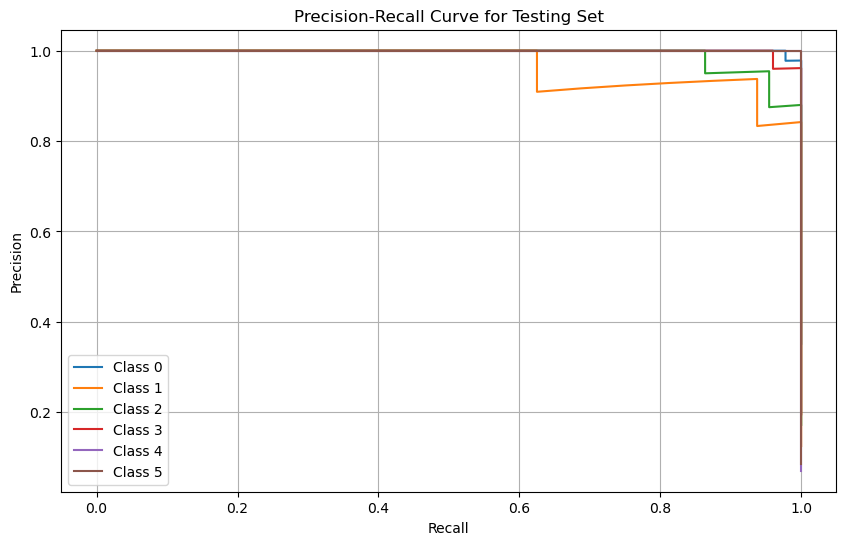

In [12]:
trained_model = train_model("ViT", train_loader, val_loader, num_classes=6, num_epochs=20, lr=0.0001)